In [86]:
# Imports
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow_datasets as tfds

%matplotlib inline

In [75]:
# load the mnist dataset from tensorflow datasets
mnist = tfds.load('mnist', with_info=False, shuffle_files=False)

print(f"Data in mnist dataset")
for data in list(mnist.keys()):
    print(f'*{data.title()}')

Data in mnist dataset
*Train
*Test


In [77]:
# Split the data to into train and test set
ds_train_orig = mnist['train']
ds_test_orig = mnist['test']

# View Dataset
print(f'Train: ', ds_train_orig)
print()
print(f'Test: ', ds_test_orig)

Train:  <_PrefetchDataset element_spec={'image': TensorSpec(shape=(28, 28, 1), dtype=tf.uint8, name=None), 'label': TensorSpec(shape=(), dtype=tf.int64, name=None)}>

Test:  <_PrefetchDataset element_spec={'image': TensorSpec(shape=(28, 28, 1), dtype=tf.uint8, name=None), 'label': TensorSpec(shape=(), dtype=tf.int64, name=None)}>


In [78]:
# Collect image and label from Prefetch Dataset
fetch_data = lambda item: (item['image'], item['label'])
ds_train_full = ds_train_orig.map(fetch_data)

# Split train set to mini-batch of 20 images eash
batch = ds_train_full.batch(20)

# Get the first batch
batch = next(iter(batch))

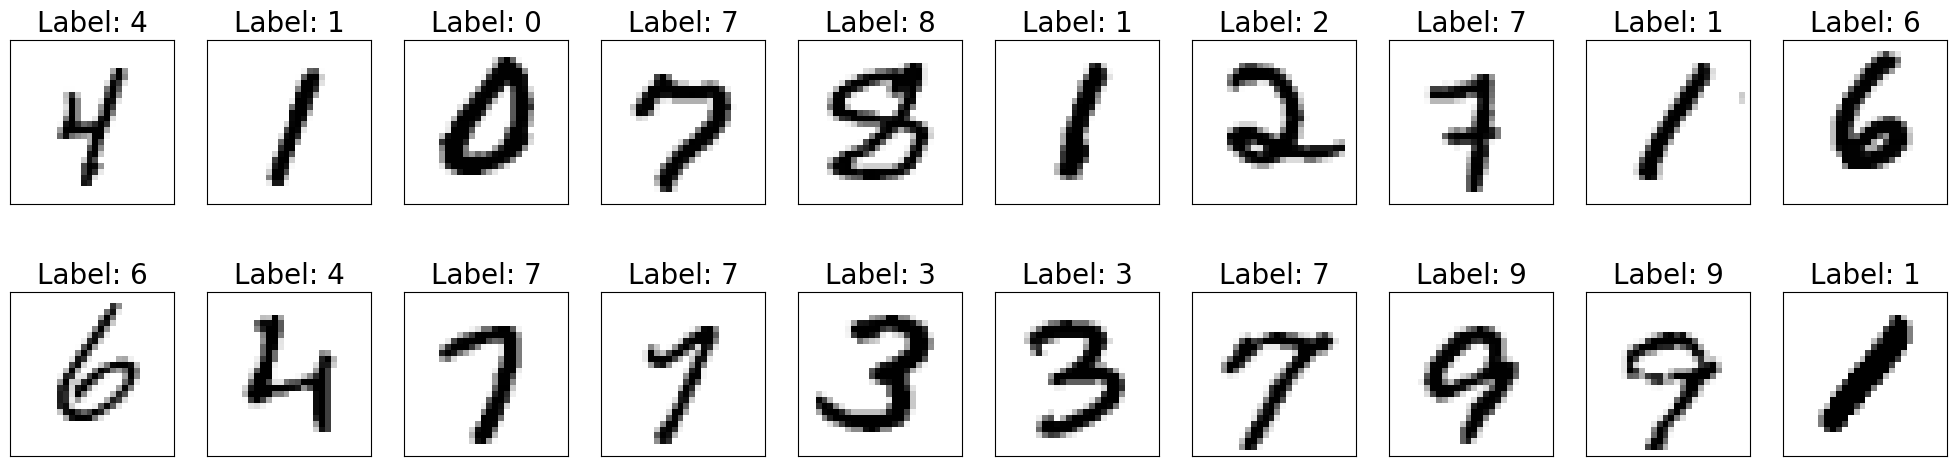

In [90]:
# Visualize the images in the batch
plt.figure(figsize=(25, 6))
for i, (img, label) in enumerate(zip(batch[0], batch[1])):
    ax = plt.subplot(2, 10, i+1)
    ax.imshow(img, cmap='gray_r')
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_title('Label: ' + str(label.numpy()), fontsize=20)


In [40]:
# image preprocessing

BUFFER_SIZE = 10000
EPOCHS = 20
BATCH_SIZE = 64


# Normalize and convert the data type
preprocessor = lambda item: (tf.cast(item['image'], tf.float32)/255.0,
                             tf.cast(item['label'], tf.int32))

ds_train = ds_train_orig.map(preprocessor)

ds_test = ds_test_orig.map(preprocessor)

# Shuffle the data set
tf.random.set_seed(1)
ds_train = ds_train.shuffle(buffer_size=BUFFER_SIZE, reshuffle_each_iteration=False)

# Split training set to Train and Validation set
ds_valid = ds_train.take(10000).batch(BATCH_SIZE)
ds_train = ds_train.skip(10000).batch(BATCH_SIZE)

In [41]:
# Construct a CNN model 
model = tf.keras.Sequential()

model.add(tf.keras.layers.Conv2D(
    filters=32, kernel_size=(5, 5), strides=(1, 1),
    padding='same', data_format='channels_last', name='conv_1', activation='relu'))

model.add(tf.keras.layers.MaxPool2D(pool_size=(2,2), name='pool_1'))

model.add(tf.keras.layers.Conv2D(
    filters=64, kernel_size=(5, 5), strides=(1, 1),
    padding='same', name='conv_2', activation='relu'))

model.add(tf.keras.layers.MaxPool2D(pool_size=(2,2), name='pool_2'))

model.add(tf.keras.layers.Flatten())

model.add(tf.keras.layers.Dense(units=1024, name='fc_1', activation='relu'))

model.add(tf.keras.layers.Dropout(rate=0.5))

model.add(tf.keras.layers.Dense(units=10, name='fc_2', activation='softmax'))

In [42]:
tf.random.set_seed(1)

# Set input shape
model.build(input_shape=(None, 28, 28, 1))

model.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(),
    metrics=['accuracy'])

In [46]:
# Train the model
history = model.fit(ds_train, epochs=EPOCHS,
                    validation_data=ds_valid,
                    shuffle=True)

Epoch 1/20
782/782 [==============================] - 7606s 10s/step - loss: 0.1387 - accuracy: 0.9564 - val_loss: 0.0524 - val_accuracy: 0.9843
Epoch 2/20
782/782 [==============================] - 62995s 81s/step - loss: 0.0459 - accuracy: 0.9858 - val_loss: 0.0392 - val_accuracy: 0.9891
Epoch 3/20
782/782 [==============================] - 28466s 36s/step - loss: 0.0311 - accuracy: 0.9900 - val_loss: 0.0397 - val_accuracy: 0.9882
Epoch 4/20
782/782 [==============================] - 30656s 39s/step - loss: 0.0233 - accuracy: 0.9925 - val_loss: 0.0389 - val_accuracy: 0.9893
Epoch 5/20
782/782 [==============================] - 6102s 8s/step - loss: 0.0186 - accuracy: 0.9941 - val_loss: 0.0456 - val_accuracy: 0.9889
Epoch 6/20
782/782 [==============================] - 5273s 7s/step - loss: 0.0169 - accuracy: 0.9945 - val_loss: 0.0406 - val_accuracy: 0.9902
Epoch 7/20
782/782 [==============================] - 3878s 5s/step - loss: 0.0137 - accuracy: 0.9954 - val_loss: 0.0498 - val_ac

In [49]:
hist_df = pd.DataFrame(history.history)
hist_df.head()

,loss,accuracy,val_loss,val_accuracy
0,0.138715,0.95644,0.052405,0.9843
1,0.045876,0.98584,0.039171,0.9891
2,0.031090,0.99004,0.039717,0.9882
3,0.023344,0.99246,0.038948,0.9893
4,0.018620,0.99406,0.045557,0.9889


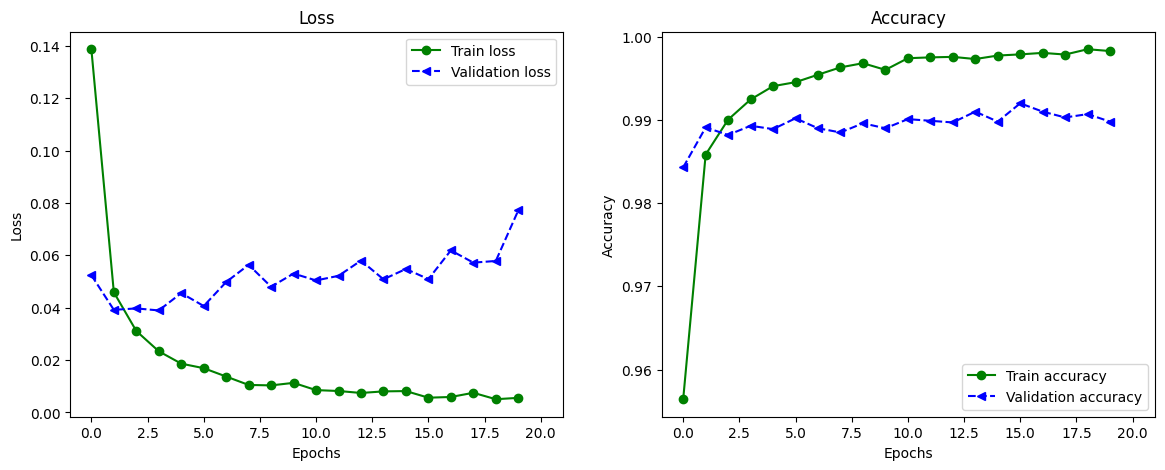

In [113]:
# Visualize the Loss and Accuracy
fig = plt.figure(figsize=(14, 5))

# Loss
ax = fig.add_subplot(1, 2, 1)
ax.plot(hist_df['loss'], '-o', c='g', label='Train loss')
ax.plot(hist_df['val_loss'], '--<', c='blue', label='Validation loss')
ax.set_title('Loss')
ax.set_xlim(None, 21)
ax.set_xlabel('Epochs')
ax.set_ylabel('Loss')
ax.legend()

# Accuracy
ax1 = fig.add_subplot(1, 2, 2)
ax1.plot(hist_df['accuracy'], '-o', c='g', label='Train accuracy')
ax1.plot(hist_df['val_accuracy'], '--<', c='blue', label='Validation accuracy')
ax1.set_title('Accuracy')
ax1.set_xlim(None, 21)
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Accuracy')
ax1.legend()
plt.show()

In [114]:
# Evaluate the model using the test set
result = model.evaluate(ds_test.batch(20))
result

500/500 [==============================] - 394s 788ms/step - loss: 0.0411 - accuracy: 0.9930


[0.041115883737802505, 0.9929999709129333]

In [115]:
# print test accuracy
print(f'Test Accuracy: {result[1]*100:.2f}%')

Test Accuracy: 99.30%


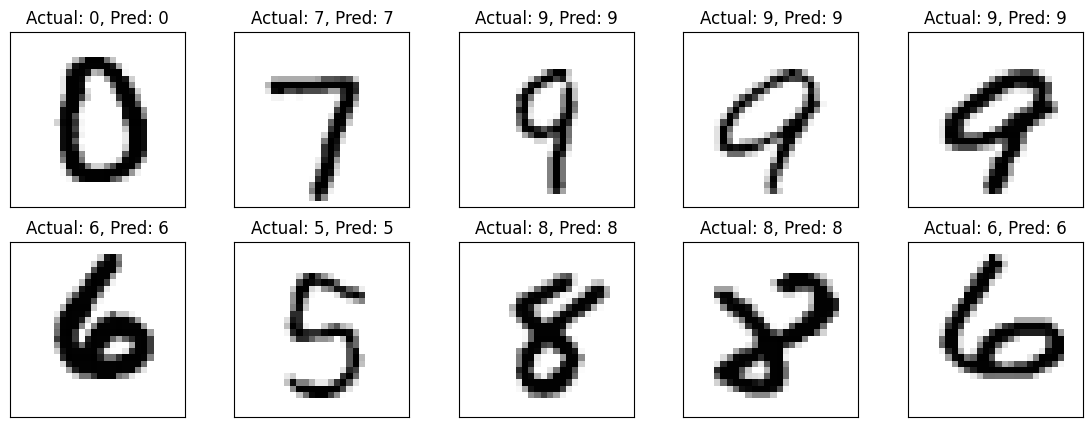

In [120]:
# Get 10 random test images
batch_test = next(iter(ds_test.batch(10).shuffle(10)))

# predict the images
preds = model(batch_test[0])
preds = tf.argmax(preds, axis=1)

# Visualize the image prediction
plt.figure(figsize=(14, 5))
for i in range(10):
    ax = plt.subplot(2, 5, i+1)
    ax.set_xticks([])
    ax.set_yticks([])
    img = batch_test[0][i, :, :, 0]
    ax.imshow(img, cmap='gray_r')
    ax.set_title(f'Actual: {batch_test[1][i]}, Pred: {preds[i]}')

In [122]:
# Saving the model
model.save('handwritten_digit.keras')
print('model saved')

model saved


In [123]:
# Loading the model
new_model = tf.keras.models.load_model('handwritten_digit.keras')
new_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv_1 (Conv2D)             (None, 28, 28, 32)        832       
                                                                 
 pool_1 (MaxPooling2D)       (None, 14, 14, 32)        0         
                                                                 
 conv_2 (Conv2D)             (None, 14, 14, 64)        51264     
                                                                 
 pool_2 (MaxPooling2D)       (None, 7, 7, 64)          0         
                                                                 
 flatten (Flatten)           (None, 3136)              0         
                                                                 
 fc_1 (Dense)                (None, 1024)              3212288   
                                                                 
 dropout (Dropout)           (None, 1024)              0